In [27]:
import gym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
%matplotlib inline

In [3]:
from PIL import Image, ImageDraw

# helper functions to plot gym images inside jupyter

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [4]:
env = gym.make("CartPole-v0")

[2017-04-21 01:16:38,662] Making new env: CartPole-v0


In [5]:
obs = env.reset()

In [6]:
obs 

# 4 observations
# 1. horizontal position of cart on x axis
# 2. velocity of cart - neg moving to the left, positive moving to the right
# 3. angle of the pole
# 4. angular velocity - neg means tilted to left, pos tilted to right

array([ 0.02667122, -0.00527884,  0.02540373, -0.02214148])

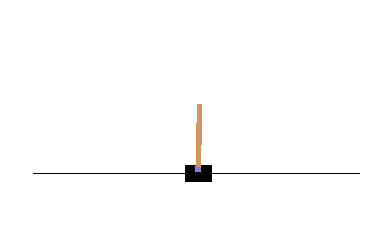

In [7]:
plot_cart_pole(env, obs)

In [8]:
env.close()

In [9]:
# possible actions

env.action_space

# 2 discrete actions
# 0 - move to the left
# 1 - move to the right

Discrete(2)

In [19]:
action = 1 # accelerate to the right

In [20]:
obs, reward, done, info = env.step(action)

In [21]:
obs

array([ 0.02620735, -0.00653527,  0.024548  ,  0.00558367])

In [22]:
reward  # always gets 1 as reward, so longer it stays up the better

1.0

In [23]:
done  # will return true when the pole tilts too much and has to be reset, when an episode is over

False

In [24]:
info  # provides extra debug info

{}

In [25]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1  # move left if tilting to the left, move right if tilting to the right

In [26]:
totals = []

for episode in range(500): # run 500 episodes, episode is reset when pole tilts too much
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): # run 1000 steps so we dont run forever
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:  # if pole tilted too much
            break
    totals.append(episode_rewards)  # keep track of rewards for each episode

In [28]:
print("Mean Reward: ", np.mean(totals)) # mean reward across 500 episodes
print("Std Dev", np.mean(totals))  
print("Min Reward", np.min(totals))  # worst performance in all episodes
print("Max Reward", np.max(totals))  # max number of steps it was able to keep it standing up for

Mean Reward:  41.806
Std Dev 41.806
Min Reward 25.0
Max Reward 72.0


In [29]:
env.close()

In [34]:
# rendering out a short animation

frames = []

env = gym.make("CartPole-v0")

max_steps = 10000
change_steps = 10

obs = env.reset()

for step in range(max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)
    
    #hard coded policy
    if obs[2] < 0:
        action = 0
    else:
        action = 1
        
    obs, reward, done, info = env.step(action)
    
    if done:
        print("Step",step)
        break
        
env.close()

[2017-04-21 01:24:46,250] Making new env: CartPole-v0


Step 38


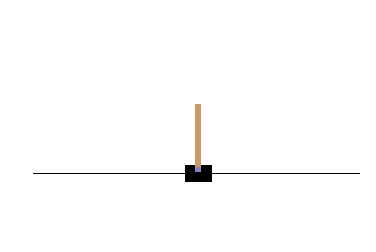

In [35]:
video = plot_animation(frames)
HTML(video.to_html5_video())

In [29]:
import tensorflow as tf

In [30]:
from tensorflow.contrib.layers import fully_connected

In [31]:
# 1 specify neural net architecture

n_inputs = 4 # number of observations
n_hidden = 4 # number of neurons in hidden layer
n_outputs = 1  # probablity of accelerating left

initializer = tf.contrib.layers.variance_scaling_initializer()

In [32]:
# build the neural network

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
hidden = fully_connected(X, n_hidden, activation_fn=tf.nn.elu,
                        weights_initializer=initializer)
logits = fully_connected(hidden, n_outputs, activation_fn=None,
                        weights_initializer=initializer)
outputs = tf.nn.sigmoid(logits)


In [33]:
# select random action based on output probability

p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

In [34]:
y = 1. - tf.to_float(action)  # target probability

learning_rate = 0.01

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(cross_entropy)

In [35]:
gradients = [grad for grad,variable in grads_and_vars]

In [36]:
gradient_placeholders = []

grads_and_vars_feed = []

for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [51]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    
    return [(discount_rewards - reward_mean)/reward_std for discount_rewards 
           in all_discounted_rewards]

In [52]:
l = discount_rewards([10,0,-50], discount_rate=0.8)

In [53]:
l.mean()

-37.333333333333336

In [54]:
l.std()

11.585431464655176

In [58]:
l

array([-22., -40., -50.])

In [59]:
(-22+37.33)/11.58

1.3238341968911915

In [60]:
discount_and_normalize_rewards([[10,0,-50], [10,20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([ 1.26665318,  1.0727777 ])]

In [62]:
n_iterations = 250   # number of training iterations
n_max_steps = 1000   # max steps per episode
n_games_per_update = 10  # train policy every 10 episodes
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    
    for iteration in range(n_iterations):
        all_rewards = []  # all sequence of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode
        
        for game in range(n_games_per_update):
            
            current_rewards = []  # all rewards from current episode
            current_gradients = [] # all gradients from current episode
            obs = env.reset()
            
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients],
                                                    feed_dict={X:obs.reshape(1, n_inputs)}) # one obs
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        # now we have run the policy for 10 episodes and are ready
        # for a policy update using the algo described before
        
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply gradient by action score and compute the mean
            mean_gradients = np.mean(
                [reward * all_gradients[game_index][step][var_index]
                for game_index, rewards in enumerate(all_rewards)
                for step,reward in enumerate(rewards)], axis=0
            )
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_cart_pole.ckpt")
        

